# STAT 4984 Final Project: Snake Breed Classification

Megan Schaeb  
4/23/2023

## Setup

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from matplotlib import ticker

### About the data 

The snake species data was gathered from [Kaggle](https://www.kaggle.com/datasets/duttadebadri/identifying-different-breeds-of-snakes?resource=download) and was inspired by HackerEarth's "Deep Learning Challenge" for classification of snake breed. The data was split into training and testing sets using the STAT4984_SplitData.ipynb file.  

The directories for the training and testing sets are structured as follows:  

    set_name 
        species_name
            img1
            img2
            ...
        species_name
            img1
            img2
            ...
        ...
    
When loading the data with the ImageFolder function, the images will be labeled using the species in the directory name. 

The code used to load the data was adapted from https://ryanwingate.com/intro-to-machine-learning/deep-learning-with-pytorch/loading-image-data-into-pytorch/ and the code used to display an image was adapted from https://datascience.stackexchange.com/questions/112918/using-dataloader-to-display-an-image.

In [2]:
# get category names
categories = os.listdir(".\\snake_train_test\\train") 
categories

['agkistrodon-contortrix',
 'agkistrodon-piscivorus',
 'coluber-constrictor',
 'crotalus-atrox',
 'crotalus-horridus',
 'crotalus-ruber',
 'crotalus-scutulatus',
 'crotalus-viridis',
 'diadophis-punctatus',
 'haldea-striatula',
 'heterodon-platirhinos',
 'lampropeltis-californiae',
 'lampropeltis-triangulum',
 'masticophis-flagellum',
 'natrix-natrix',
 'nerodia-erythrogaster',
 'nerodia-fasciata',
 'nerodia-rhombifer',
 'nerodia-sipedon',
 'opheodrys-aestivus',
 'pantherophis-alleghaniensis',
 'pantherophis-emoryi',
 'pantherophis-guttatus',
 'pantherophis-obsoletus',
 'pantherophis-spiloides',
 'pantherophis-vulpinus',
 'pituophis-catenifer',
 'rhinocheilus-lecontei',
 'storeria-dekayi',
 'storeria-occipitomaculata',
 'thamnophis-elegans',
 'thamnophis-marcianus',
 'thamnophis-proximus',
 'thamnophis-radix',
 'thamnophis-sirtalis']

### Loading the Data

In [3]:
# define image transform: convert to tensor, resize 
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])

# get datasets of images
train_set = datasets.ImageFolder(".\\snake_train_test\\train", transform=transform)
test_set = datasets.ImageFolder(".\\snake_train_test\\test", transform=transform)

# pass image datasets to data loader
train = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) 
test = torch.utils.data.DataLoader(test_set, batch_size=50, shuffle=False)

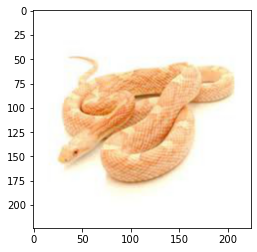

tensor(23)


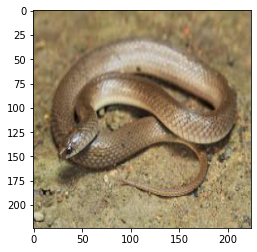

tensor(9)


In [4]:
# show a sample of images
# Source code: https://datascience.stackexchange.com/questions/112918/using-dataloader-to-display-an-image
images, labels = next(iter(train))
plt.imshow(images[10].permute(1,2,0))
plt.show()
print(labels[10])

plt.imshow(images[1].permute(1,2,0))
plt.show()
print(labels[1])

## Building the Model

The code used to build the ResNet model was written by Youhui Ye in ResNet_stud.ipynb, available on Canvas, with minor changes made to fit the 224 x 224 image size and ResNet-18 structure. 

In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, channels, stride=1):
        '''
        Initailize a basic block with 2 convolutional layers
        
        Inputs
        ------
        in_channels: number of channels being passed into a layer
        channels: number of out channels for a layer
        stride: stride for the layer
        '''
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels, channels, kernel_size=3, stride=stride, padding=1, bias=False)
        
        # apply batch normalization
        self.bn1 = nn.BatchNorm2d(channels)
        
        # for any layer that is not the first layer in the ResNet convolutional layer, stride = 1
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn2 = nn.BatchNorm2d(channels)

        self.shortcut = nn.Sequential()
        
        # ResNet18: stride != 1 when the # of channels changes
        if stride != 1 or in_channels != self.expansion*channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion*channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*channels)
            )

    def forward(self, x):
        '''
        Run the input through the block
        
        Input
        -----
        x: input images
        
        Returns
        -------
        Output categories for the images
        '''
        out = F.relu(self.bn1(self.conv1(x)))  # apply ReLU to normalized CONV1
        out = self.bn2(self.conv2(out))  # normalize CONV2
        out += self.shortcut(x)  # add input to the output of CONV2
        out = F.relu(out)  # apply ReLU to F(x) + x
        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=35):
        '''
        Initialize a ResNet model
        
        Inputs
        ------
        block: Block object for the type of block desired (Basic or Bottleneck)
        num_blocks: number of blocks to include in each layer of the model
        num_classes: number of classes in which to classify the input images
        '''
        
        super(ResNet, self).__init__()
        self.in_channels = 64  # number of in channels in the first convolutional layer

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # first layer in the model
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)  # 64 out channels
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)  # 64 in channels, 128 out channels
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)  # 128 in channels, 256 out channels
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)  # 256 in channels, 512 out channels
        self.linear = nn.Linear(512*block.expansion, num_classes)  # fully connected layer; 512x1 in, num_classesx1 out

    def _make_layer(self, block, channels, num_blocks, stride):
        '''
        Create a block of the specified type with the specified number of in_channels, out channels, and stride.
        Update the in_channels variable to be the number of out_channels used to create the block.
        Add the block to the Sequential object.
        
        Inputs
        ------
        block: Block object for the type of block desired (Basic or Bottleneck)
        channels: number of out channels for a layer
        num_blocks: number of blocks to include in the layer
        stride: stride for the layer
        
        Returns
        -------
        Sequential object containing the layers of the block
        '''
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, channels, stride))
            self.in_channels = channels * block.expansion   # update in_channels to be out_channels from the previous conv.
        return nn.Sequential(*layers)

    def forward(self, x):
        '''
        Run the input through the model
        
        Input
        -----
        x: input images
        
        Returns
        -------
        Output categories for input images
        '''
        out = F.relu(self.bn1(self.conv1(x)))  
        out = F.max_pool2d(out, 3, stride=2, padding=1)   # apply max pooling
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 7)  # apply average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [7]:
def ResNet18():
    '''
    ResNet model with 18 layers (2 building blocks per convolutional layer)
    '''
    return ResNet(BasicBlock, [2, 2, 2, 2])

## Train the Model

Train one model using the Adam optimizer and one model using SGD with momentum = 0.9.

In [8]:
# Set hyper-parameters 
num_epochs = 10
learning_rate = 0.001

# instantiate models
model1 = ResNet18()
model2 = ResNet18()

# Setup loss function and optimizers
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.9)

# Lists for tracking loss over epochs
model1_loss = []
model2_loss = []

In [9]:
# Train the model with the Adam optimizer
total_step = len(train)  # number of images per batch
curr_lr = learning_rate
for epoch in range(num_epochs):
    epoch_loss = 0   # track loss over the epoch
    for i, (images, labels) in enumerate(train):
        images = images
        labels = labels

        # Forward pass
        outputs = model1(images)
        loss = criterion1(outputs, labels)

        # Backward and optimize
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        
        epoch_loss += loss.item()

        if (i+1) % 10 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    # append average loss for the epoch to the loss list for this model
    model1_loss.append(epoch_loss/total_step)
    
print('Done with training.')

Epoch [1/10], Step [10/211] Loss: 4.0972
Epoch [1/10], Step [20/211] Loss: 3.6711
Epoch [1/10], Step [30/211] Loss: 3.6211
Epoch [1/10], Step [40/211] Loss: 3.4906
Epoch [1/10], Step [50/211] Loss: 3.3941
Epoch [1/10], Step [60/211] Loss: 3.5049
Epoch [1/10], Step [70/211] Loss: 3.5087
Epoch [1/10], Step [80/211] Loss: 3.6259
Epoch [1/10], Step [90/211] Loss: 3.4319
Epoch [1/10], Step [100/211] Loss: 3.5290
Epoch [1/10], Step [110/211] Loss: 3.3531
Epoch [1/10], Step [120/211] Loss: 3.4303
Epoch [1/10], Step [130/211] Loss: 3.5080
Epoch [1/10], Step [140/211] Loss: 3.3762
Epoch [1/10], Step [150/211] Loss: 3.3673
Epoch [1/10], Step [160/211] Loss: 3.4073
Epoch [1/10], Step [170/211] Loss: 3.4236
Epoch [1/10], Step [180/211] Loss: 3.3196
Epoch [1/10], Step [190/211] Loss: 3.4269
Epoch [1/10], Step [200/211] Loss: 3.5043
Epoch [1/10], Step [210/211] Loss: 3.1866
Epoch [2/10], Step [10/211] Loss: 3.2058
Epoch [2/10], Step [20/211] Loss: 3.4567
Epoch [2/10], Step [30/211] Loss: 3.2245
Epoc

Epoch [10/10], Step [90/211] Loss: 2.0014
Epoch [10/10], Step [100/211] Loss: 2.4247
Epoch [10/10], Step [110/211] Loss: 1.7426
Epoch [10/10], Step [120/211] Loss: 2.1410
Epoch [10/10], Step [130/211] Loss: 2.1152
Epoch [10/10], Step [140/211] Loss: 1.7758
Epoch [10/10], Step [150/211] Loss: 2.0167
Epoch [10/10], Step [160/211] Loss: 2.1626
Epoch [10/10], Step [170/211] Loss: 1.8663
Epoch [10/10], Step [180/211] Loss: 1.9889
Epoch [10/10], Step [190/211] Loss: 2.4912
Epoch [10/10], Step [200/211] Loss: 2.2972
Epoch [10/10], Step [210/211] Loss: 2.0785
Done with training.


In [10]:
# Train the model with the SGD optimizer
total_step = len(train)  # number of images per batch
curr_lr = learning_rate
for epoch in range(num_epochs):
    epoch_loss = 0
    for i, (images, labels) in enumerate(train):
        images = images
        labels = labels

        # Forward pass
        outputs = model2(images)
        loss = criterion2(outputs, labels)

        # Backward and optimize
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()

        if (i+1) % 10 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    # append average loss for the epoch to the loss list for this model
    model2_loss.append(epoch_loss/total_step)
    
print('Done with training.')

Epoch [1/10], Step [10/211] Loss: 3.5937
Epoch [1/10], Step [20/211] Loss: 3.5465
Epoch [1/10], Step [30/211] Loss: 3.5432
Epoch [1/10], Step [40/211] Loss: 3.4907
Epoch [1/10], Step [50/211] Loss: 3.3695
Epoch [1/10], Step [60/211] Loss: 3.4036
Epoch [1/10], Step [70/211] Loss: 3.3976
Epoch [1/10], Step [80/211] Loss: 3.4645
Epoch [1/10], Step [90/211] Loss: 3.3134
Epoch [1/10], Step [100/211] Loss: 3.3299
Epoch [1/10], Step [110/211] Loss: 3.4129
Epoch [1/10], Step [120/211] Loss: 3.2623
Epoch [1/10], Step [130/211] Loss: 3.3602
Epoch [1/10], Step [140/211] Loss: 3.1478
Epoch [1/10], Step [150/211] Loss: 3.4200
Epoch [1/10], Step [160/211] Loss: 3.3283
Epoch [1/10], Step [170/211] Loss: 3.3613
Epoch [1/10], Step [180/211] Loss: 3.3282
Epoch [1/10], Step [190/211] Loss: 3.4730
Epoch [1/10], Step [200/211] Loss: 3.1934
Epoch [1/10], Step [210/211] Loss: 3.4344
Epoch [2/10], Step [10/211] Loss: 3.2047
Epoch [2/10], Step [20/211] Loss: 3.2840
Epoch [2/10], Step [30/211] Loss: 2.9663
Epoc

Epoch [10/10], Step [90/211] Loss: 0.3737
Epoch [10/10], Step [100/211] Loss: 0.4104
Epoch [10/10], Step [110/211] Loss: 0.2735
Epoch [10/10], Step [120/211] Loss: 0.4451
Epoch [10/10], Step [130/211] Loss: 0.2856
Epoch [10/10], Step [140/211] Loss: 0.3543
Epoch [10/10], Step [150/211] Loss: 0.3358
Epoch [10/10], Step [160/211] Loss: 0.4442
Epoch [10/10], Step [170/211] Loss: 0.5169
Epoch [10/10], Step [180/211] Loss: 0.4512
Epoch [10/10], Step [190/211] Loss: 0.4503
Epoch [10/10], Step [200/211] Loss: 0.4782
Epoch [10/10], Step [210/211] Loss: 0.3782
Done with training.


### Plot Training Loss

In [11]:
# Average training loss for model with Adam optimizer
print(model1_loss)

[3.5047766925034365, 3.31554699170081, 3.1811592601486858, 3.052712434840993, 2.912207300629096, 2.75742331500302, 2.6223938939695675, 2.464083275523796, 2.2995314281698653, 2.0759740146980468]


In [12]:
# Average training loss for model with SGD with momentum optimizer
print(model2_loss)

[3.381685113454882, 3.0943463707422194, 2.869127835142669, 2.638190744047481, 2.365851570079677, 2.0786717141409055, 1.6562205519156434, 1.219526437221545, 0.7630670631383832, 0.4163614743834988]


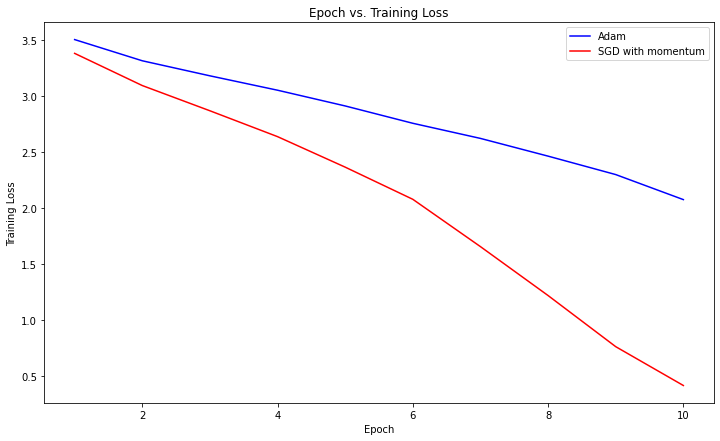

In [13]:
# Plot training losses
fig0 = plt.figure()
fig0.set_figwidth(12)
fig0.set_figheight(7)
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], model1_loss, color="blue")
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], model2_loss, color="red")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Epoch vs. Training Loss")
plt.legend(["Adam", "SGD with momentum"])
plt.savefig("loss_plot_run2.jpeg")
plt.savefig("loss_plot_run2.png")

fig0.savefig("SGDvAdamLoss10.jpeg")

## Test the Model

The code used to construct the confusion matrices was sourced from STAT4984_week07_code.ipynb written by Xin Xing and available on Canvas.

In [14]:
# Keep track of correct guesses in a confusion matrix
num_classes = 35
confusion1 = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test:
        images = images
        labels = labels
        outputs1 = model1(images)
        _, predicted1 = torch.max(outputs1.data, 1)
        total += labels.size(0)
        correct += (predicted1 == labels).sum().item()
        
        for i in range(0, len(predicted1)):
            confusion1[labels[i]][predicted1[i]] += 1 
        
    print('Accuracy of model1 (Adam) on the test images: {} %'.format(100 * correct / total))

Accuracy of model1 (Adam) on the test images: 6.800151114469211 %


<ipython-input-15-f3cd89cbf0e2>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([''] + categories, rotation=90)
<ipython-input-15-f3cd89cbf0e2>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([''] + categories)


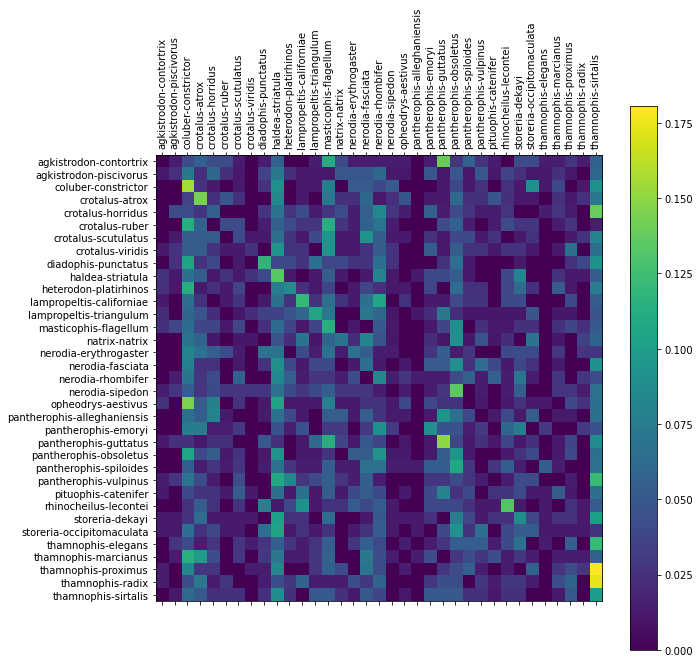

In [15]:
# Normalize by dividing every row by its sum (sum of entries across rows add up to 1)
from matplotlib import ticker

for i in range(num_classes):
    confusion1[i] = confusion1[i] / confusion1[i].sum()

# Set up plot (confusion matrix)
fig1 = plt.figure()
fig1.set_figwidth(10)
fig1.set_figheight(10)

ax1 = fig1.add_subplot()
cax1 = ax1.matshow(confusion1.numpy())
fig1.colorbar(cax1)

# Set up axes
ax1.set_xticklabels([''] + categories, rotation=90)
ax1.set_yticklabels([''] + categories)

# Force label at every tick
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()
fig1.savefig("AdamConfusionMat10.jpeg")

In [16]:
# Keep track of correct guesses in a confusion matrix
num_classes = 35
confusion2 = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test:
        images = images
        labels = labels
        outputs2 = model2(images)
        _, predicted2 = torch.max(outputs2.data, 1)
        total += labels.size(0)
        correct += (predicted2 == labels).sum().item()
        
        for i in range(0, len(predicted2)):
            confusion2[labels[i]][predicted2[i]] += 1 

    print('Accuracy of model2 (SGD) on the test images: {} %'.format(100 * correct / total))

Accuracy of model2 (SGD) on the test images: 14.88477521722705 %


<ipython-input-17-ecf6000a9d77>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([''] + categories, rotation=90)
<ipython-input-17-ecf6000a9d77>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([''] + categories)


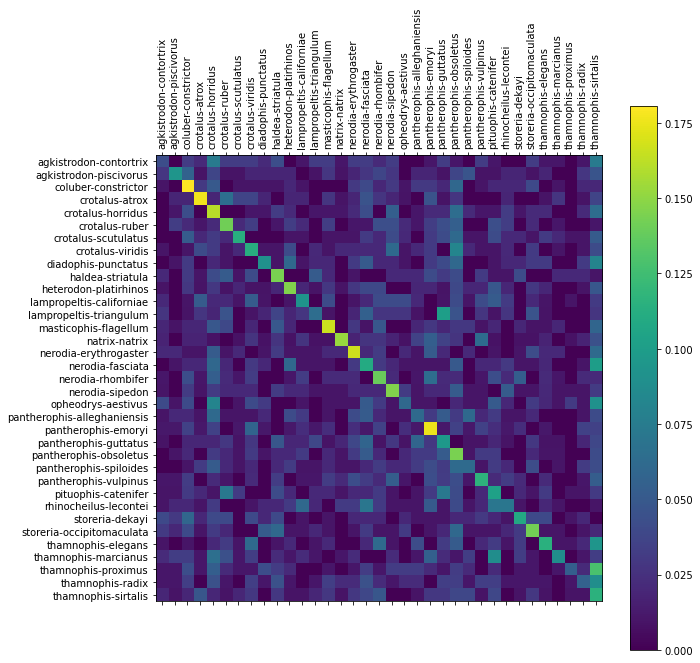

In [17]:
# Normalize by dividing every row by its sum (sum of entries across rows add up to 1)
for i in range(num_classes):
    confusion2[i] = confusion2[i] / confusion2[i].sum()

# Set up plot (confusion matrix)
fig2 = plt.figure()
fig2.set_figwidth(10)
fig2.set_figheight(10)
ax2 = fig2.add_subplot(111)
cax2 = ax2.matshow(confusion2.numpy())
fig2.colorbar(cax1)

# Set up axes
ax2.set_xticklabels([''] + categories, rotation=90)
ax2.set_yticklabels([''] + categories)

# Force label at every tick
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()
fig2.savefig("SGDConfusionMat10.jpeg")

## Conclusions

From both the training loss plot and the confusion matrices, the model using the SGD with momentum optimizer performs better than the model with the Adam optimizer. The SGD model had a lower training loss over all ten epochs and its confusion matrix shows better image classification with higher proportions of correct predictions than the Adam model. Additionally, the accuracy of the Adam model on predicting test images was 6.800151114469211% to the SGD model's 14.88477521722705%. Overall, the model with the SGD optimizer seems better suited to handle this snake breed classification problem. 